# Preprocess actual calcium data

This script preprocesses the calcium data before training. It performs two essential steps:

- low-pass filtering the calcium signal
- Inferring the time delay between image presentation and calcium recording

The low-pass filter is a butterworth filter.

The inference of delay happens by performing linear regression from images onto calcium signal and choosing that delay which leads to the smallest MSE on average across all ROIs.

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import matplotlib as mpl
import scipy

In [2]:
all_dfs = pd.read_pickle("results/data/setup.pkl")

In [3]:
def get_stim_and_calcium(one_roi):
    """Interpolates the noise stimulus and align it temporally with calcium."""
            
    noise_times = one_roi["Triggertimes_noise"]
    calcium_at_roi = one_roi["Traces0_raw_noise"]
    times_calcium = one_roi["Tracetimes0_noise"]

    # Throw out calcium from before the noise.
    condition = times_calcium > np.min(noise_times)
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]

    # Throw out calcium from after 200ms after the last noise trigger.
    condition = times_calcium < np.max(noise_times) + 0.2
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]
    
    interpolated_noise = np.zeros((noise_stimulus.shape[0], noise_stimulus.shape[1], len(times_calcium)))  # np.interp(times_calcium, joined_times, joined_stim)
    for i in range(15):
        for j in range(20):
            interpolator = scipy.interpolate.interp1d(noise_times, noise_stimulus[i, j], kind="zero", fill_value="extrapolate")
            interpolated_noise[i, j, :] = interpolator(times_calcium)

    # Align calcium and stimulus.
    temporal_delay_steps = 10
    calcium_at_roi = calcium_at_roi[temporal_delay_steps:]
    times_calcium = times_calcium[temporal_delay_steps:]
    interpolated_noise = interpolated_noise[:, :, :-temporal_delay_steps]

    return interpolated_noise, calcium_at_roi, times_calcium, noise_times

In [4]:
cell_id = "20170610_1"

In [22]:
def lowpass_calcium(df):
    noise_times = one_roi["Triggertimes_noise"]
    calcium_at_roi = one_roi["Traces0_raw_noise"]
    times_calcium = one_roi["Tracetimes0_noise"]

    # Throw out calcium from before the noise.
    condition = times_calcium > np.min(noise_times)
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]

    # Throw out calcium from after 400ms after the last noise trigger.
    condition = times_calcium < np.max(noise_times) + 0.4
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]

    mean_calcium = np.mean(calcium_at_roi)
    std_calcium = np.std(calcium_at_roi)
    raw_calcium = (calcium_at_roi - mean_calcium) / std_calcium
    sos = signal.butter(4, 7.0, 'low', fs=31.25, output='sos')
    filtered_calcium = signal.sosfilt(sos, raw_calcium)
    return filtered_calcium, raw_calcium, times_calcium, noise_times


def delay_and_subsample_calcium(calcium, times_calcium, noise_times, temporal_delay_steps: int = 5):
    interpolated_noise = np.zeros((noise_stimulus.shape[0], noise_stimulus.shape[1], len(times_calcium)))
    noise_index = np.arange(noise_stimulus.shape[2])
    noise_times = noise_times[:1500]
    interpolator = scipy.interpolate.interp1d(noise_times, noise_index, kind="zero", fill_value="extrapolate")
    interpolated_index = interpolator(times_calcium)

    calcium = calcium[temporal_delay_steps:]
    times_calcium = times_calcium[temporal_delay_steps:]
    interpolated_noise_index = interpolated_index[:-temporal_delay_steps]

    diff_X = np.concatenate([np.diff(interpolated_noise_index), [0]]) > 0.0
    last_calcium_per_image = calcium[diff_X]
    last_time_per_image = times_calcium[diff_X]

    return last_calcium_per_image, last_time_per_image

In [23]:
one_morph = all_dfs[all_dfs["cell_id"] == cell_id]

# Read stimulus information.
file = h5py.File("data/noise2.h5", 'r+')
noise_stimulus = file["k"][()]

counter = 0
for df in one_morph[:1].iterrows():
    index = df[0]
    one_roi = df[1]
    filtered_calcium, raw_calcium, times_calcium, noise_times = lowpass_calcium(one_roi)
    subsampled_calcium, subsampled_times = delay_and_subsample_calcium(
        filtered_calcium, 
        times_calcium, 
        noise_times, 
        temporal_delay_steps=5
    )

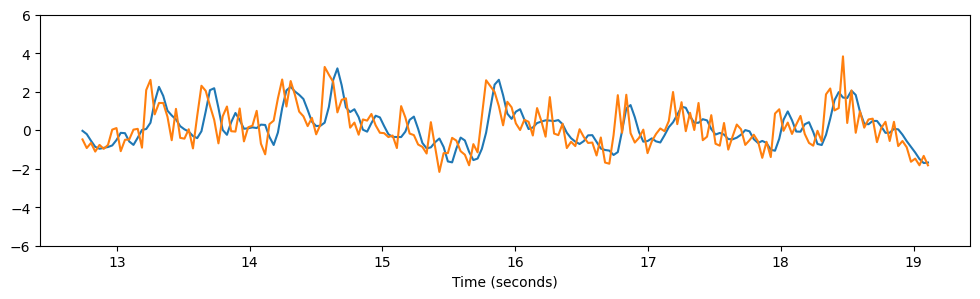

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(times_calcium[:200], filtered_calcium[:200])
_ = ax.plot(times_calcium[:200], raw_calcium[:200])
_ = ax.set_xlabel("Time (seconds)")
_ = ax.set_ylim([-6, 6])

### Low-pass filter

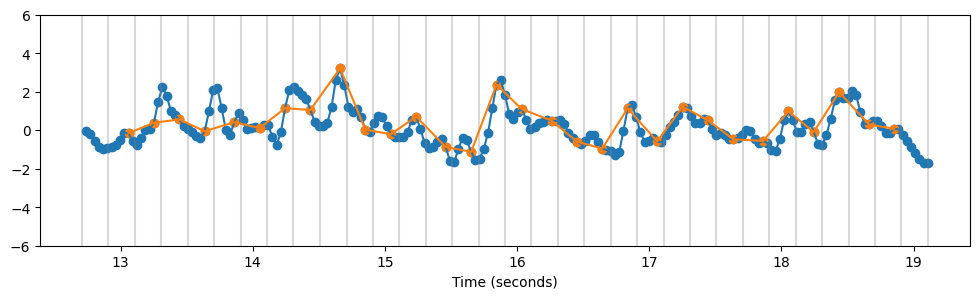

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(times_calcium[:200], filtered_calcium[:200])
_ = ax.scatter(times_calcium[:200], filtered_calcium[:200])

for i in range(33):
    _ = ax.axvline(noise_times[i], c="gray", alpha=0.3)

_ = ax.plot(subsampled_times[:30], subsampled_calcium[:30])
_ = ax.scatter(subsampled_times[:30], subsampled_calcium[:30])

_ = ax.set_xlabel("Time (seconds)")
_ = ax.set_ylim([-6, 6])

### Perform linear regression onto the last calcium value in order to identify the optimal time lag

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from scipy.spatial.distance import correlation

In [28]:
all_accs_across_rois = []
shifts = np.arange(6, 14)
for j, df in enumerate(one_morph.iterrows()):
    one_roi = df[1]
    filtered, _, times_calcium, noise_times = lowpass_calcium(one_roi)
    all_accs = []
    for i in shifts:
        subsampled_calcium, subsampled_times = delay_and_subsample_calcium(
            filtered, 
            times_calcium, 
            noise_times, 
            temporal_delay_steps=i
        )

        data = noise_stimulus.reshape((300, 1500)).T[:1498]
        target = subsampled_calcium[:1498]

        clf = LinearRegression()
        shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
        scores = cross_val_score(
            clf, data, target, cv=shuffle, scoring="neg_mean_absolute_error", verbose=0
        )
        cross_val_acc = np.mean(scores)
        all_accs.append(cross_val_acc)
    print("j", j, "acc", np.asarray(all_accs) + 1.0)
    all_accs_across_rois.append(all_accs)

j 0 acc [0.17212546 0.26178575 0.35496651 0.36419251 0.27025972 0.14072617
 0.11644285 0.20490459]
j 1 acc [0.13376962 0.2077333  0.31368418 0.36550729 0.2535944  0.0894368
 0.05895649 0.15239682]
j 2 acc [0.13719884 0.23208951 0.34564111 0.3809534  0.24338545 0.09164132
 0.08629803 0.18718227]
j 3 acc [0.13328364 0.22857711 0.32682918 0.36065375 0.25258136 0.11578252
 0.09399799 0.19942808]
j 4 acc [0.17010842 0.24815693 0.3304243  0.36758267 0.26354138 0.12180066
 0.08933078 0.16876876]
j 5 acc [0.1902575  0.25683284 0.3430595  0.36957316 0.26332346 0.15301776
 0.14587836 0.21172539]
j 6 acc [0.14080653 0.2587289  0.35597909 0.36351929 0.23358521 0.1018025
 0.0893153  0.18559366]
j 7 acc [0.16964167 0.24519137 0.33674171 0.36739386 0.29717379 0.17546195
 0.13504849 0.20615638]
j 8 acc [0.18744185 0.25293661 0.33684883 0.38093732 0.30418757 0.1843475
 0.15220253 0.2223511 ]
j 9 acc [0.22539288 0.31556695 0.39286903 0.40284237 0.2962126  0.17606984
 0.17223012 0.24894354]
j 10 acc [0.2

average_acc [0.28187227 0.29898503 0.34457979 0.37335571 0.33330515 0.25096293
 0.20040426 0.21117788]
best shift:  9


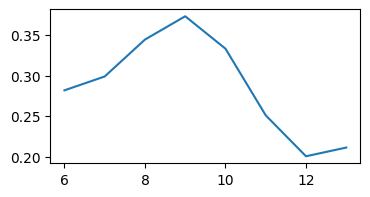

In [29]:
average_acc = np.mean(all_accs_across_rois, axis=0) + 1.0
print("average_acc", average_acc)
best_shift = shifts[np.argmax(average_acc)]
print("best shift: ", best_shift)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(shifts, average_acc)

# Save calcium labels (low-pass filtered and time-delayed)

In [32]:
inds = []
cell_ids = []
rec_ids = []
roi_ids = []
labels = []

for df in one_morph.iterrows():
    index = df[0]
    one_roi = df[1]
    roi_ids.append(one_roi["roi_id"])
    rec_ids.append(one_roi["rec_id"])
    cell_ids.append(one_roi["cell_id"])
    inds.append(index)

    filtered, _, times_calcium, noise_times = lowpass_calcium(one_roi)
    subsampled_calcium, subsampled_times = delay_and_subsample_calcium(
        filtered, 
        times_calcium, 
        noise_times, 
        temporal_delay_steps=best_shift
    )
    labels.append(subsampled_calcium[:1498].tolist())

In [34]:
labels = pd.DataFrame().from_dict(
    {
        "inds": inds,
        "cell_id": cell_ids,
        "rec_id": rec_ids,
        "roi_id": roi_ids,
        "ca": labels, 
    }
)
labels.to_pickle(f"results/data/labels_lowpass_{cell_id}.pkl")

# Deconvolve: not actually done

In [ ]:
def deconvole(noisy, kernel, t_full, t_kernel):
    signal_fft = np.fft.fft(noisy)
    kernel_fft = np.fft.fft(kernel)
    
    signal_freq = np.fft.fftfreq(t_full.shape[-1])
    kernel_freq = np.fft.fftfreq(t_kernel.shape[-1])

    sorted_signal_freq = np.argsort(signal_freq)
    signal_freq = signal_freq[sorted_signal_freq]
    signal_fft = signal_fft[sorted_signal_freq]
    
    sorted_kernel_freq = np.argsort(kernel_freq)
    kernel_freq = kernel_freq[sorted_kernel_freq]
    kernel_fft = kernel_fft[sorted_kernel_freq]
    
    interpolated_kernel_f = np.interp(signal_freq, kernel_freq, kernel_fft)
    
    division = signal_fft / interpolated_kernel_f
    recovered = np.fft.ifft(division)
    return recovered

In [278]:
kernel = np.zeros((200,))
t_kernel = np.arange(0, 200 * 0.03, 0.03)
calcium_kernel = np.exp(-t_kernel * 3.0)

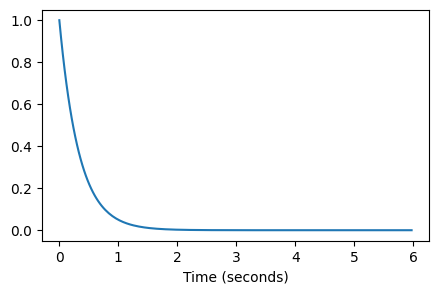

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = ax.plot(t_kernel, calcium_kernel)
_ = ax.set_xlabel("Time (seconds)")

In [280]:
recovered = deconvole(filtered[:1000], calcium_kernel, t_full[:1000], t_kernel)

### Deconvolve Toy Data

In [341]:
t_full = np.arange(10_000)
t = np.arange(1000)
kernel = np.zeros((1000,))
kernel = np.exp(-t / 100)

In [222]:
signal = np.zeros_like(t_full)
signal[[2100, 2180, 3000, 3100, 3200, 7000, 7010, 8000]] = 1.0
noisy = np.convolve(signal, kernel, mode="full")

noisy = noisy[:len(signal)]

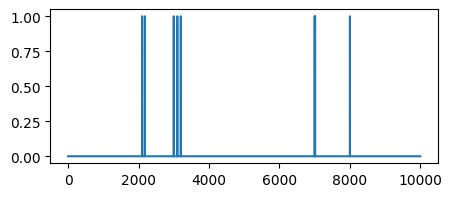

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plt.plot(t_full, signal)

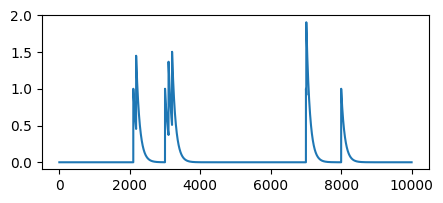

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plt.plot(t_full, noisy)

/Users/michaeldeistler/anaconda3/envs/nex/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/michaeldeistler/anaconda3/envs/nex/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


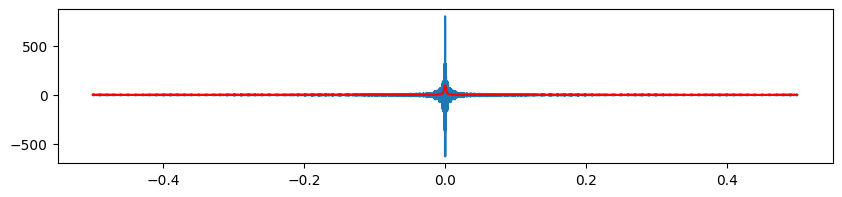

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(signal_freq, signal_fft)
ax.plot(kernel_freq, kernel_fft, c="r", zorder=1000)

In [227]:
recovered = deconvole(noisy, kernel, t_full, t)

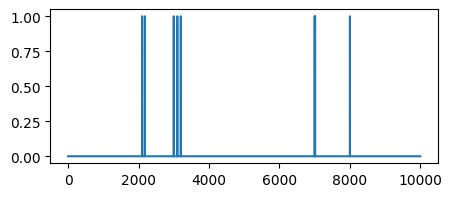

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plt.plot(t_full, signal)

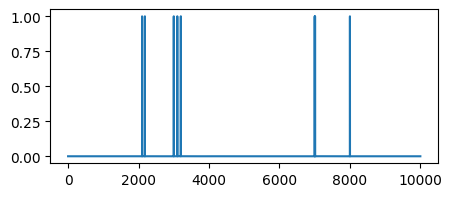

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plt.plot(np.abs(recovered))

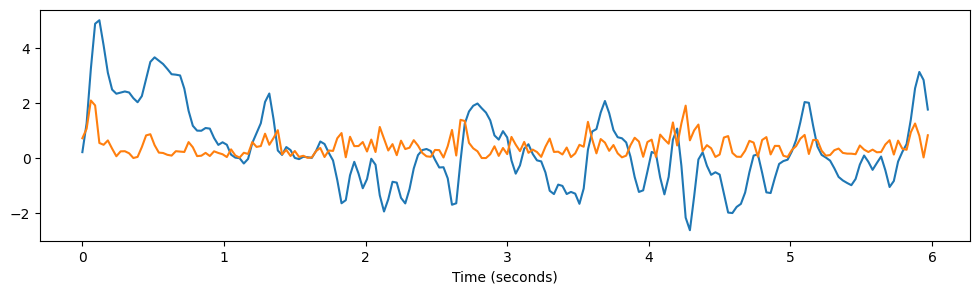

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(t_full[:200], filtered[:200])
_ = ax.plot(t_full[:200], np.abs(recovered[:200]))
_ = ax.set_xlabel("Time (seconds)")

In [282]:
np.corrcoef(np.abs(filtered[:1000]), np.abs(recovered)[:1000])[0, 1]

0.19574221273561238